In [1]:
import numpy as np
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow.keras.preprocessing.image as process_im
import pprint
import IPython.display
import cv2
import csv

In [2]:
pp = pprint.PrettyPrinter(indent=4)
vgg = tf.keras.applications.VGG19(include_top=False, weights= 'imagenet')

vgg.trainable = False
pp.pprint(vgg)

80134624/80134624 [==============================] - 23s 0us/step


In [3]:
content_img_path = 'WhatsApp Image 2023-03-01 at 17.21.44.jpg'
style_img_path = 'city-buildings-cartoon-vector-22896067.jpg'

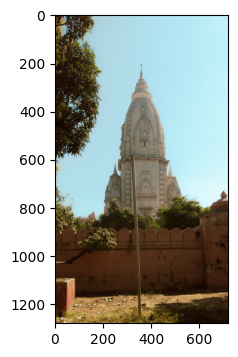

In [4]:
plt.figure(figsize=(6,4))
img = load_img(content_img_path)
plt.imshow(img)
plt.show()

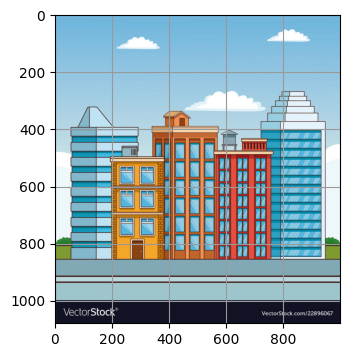

In [5]:
plt.figure(figsize=(6,4))
img = load_img(style_img_path)
plt.imshow(img)
plt.grid(color='#999999', linestyle='-')
plt.show()

In [6]:
def load_file(img_path):
    image =  Image.open(img_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0)
    return im_array

In [7]:
def img_preprocess(img_path):
    image = load_file(img_path)
    img = tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [8]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x,0)
    assert len(x.shape) == 3
    x[ :, :, 0] += 103.939
    x[ :, :, 1] += 116.779
    x[ :, :, 2] += 123.68
    x = np.clip(x , 0, 255).astype('uint8')
    return x

In [9]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
content_layers = ['block5_conv1',
                'block5_conv2']

In [11]:
style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1']

In [12]:
def get_model():
    content_output = [vgg.get_layer(layer).output for layer in content_layers]
    style_output = [vgg.get_layer(layer).output for layer in style_layers]
    model_output = content_output + style_output
    return Model(vgg.input, model_output)

In [13]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [14]:
model =get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
content_img = load_file(content_img_path)
content_img.shape

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [ ]:
style_img = load_file(style_img_path)
style_img.shape

In [ ]:
def get_content_loss(generated_img, content_img):
    content_loss = tf.reduce_sum(tf.square(content_img - generated_img))/(4*512*288*3)
    return content_loss

In [ ]:
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    vector = tf.reshape(tensor, [-1, channels])
    n =tf.shape(vector)[0]
    gram_matrix = tf.matmul(vector,vector, transpose_a = True)
    return gram_matrix/tf.cast(n, tf.float32)

In [ ]:
def get_style_loss(generated_img, style_img):
    gram_noise = gram_matrix(generated_img)
    style_loss = tf.reduce_mean(tf.square(style_img - gram_noise))
    return style_loss

In [ ]:
def get_features(model, content_img_path, style_img_path):
    content_img = img_preprocess(content_img_path)
    style_img = img_preprocess(style_img_path)
    
    content_output = model(content_img)
    style_output = model(style_img)
    
    content_feature = [layer[0] for layer in content_output[len(style_layers):]]
    style_feature = [layer[0] for layer in style_output[:len(style_layers)]]
    return content_feature, style_feature

In [ ]:
def compute_loss(model, loss_weights, image, gram_style_features, content_features):
    beta, alpha = loss_weights
    output = model(image)
    content_loss = 0
    style_loss = 0
    
    generated_img_style_feature = output[:len(style_layers)]
    generated_img_content_feature = output[len(style_layers):]
    
    alpha_per_layer = 1.0/float(len(content_layers))
    for a,b in zip(generated_img_content_feature, content_features):
        content_loss += alpha_per_layer*get_content_loss(a[0],b)
    
    beta_per_layer = 1.0/float(len(style_layers))
    for a,b in zip(gram_style_features, generated_img_style_feature):
        style_loss += beta_per_layer*get_style_loss(b[0], a)
    
    style_loss *= beta
    content_loss *= alpha
    
    total_loss = content_loss + style_loss
    
    return total_loss, content_loss, style_loss

In [ ]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_losses = compute_loss(**dictionary)
    total_loss = all_losses[0]
    y = tape.gradient(total_loss, dictionary['image'])
    return y, all_losses

In [ ]:
def style_transfer(content_img_path, style_img_path, epochs = 500, alpha =20, beta = 1e-32):
    model = get_model()
    
    for layer in model.layers:
        layer.trainable = False
    
    content_feature, style_feature = get_features(model, content_img_path, style_img_path)
    
    style_gram_matrix = [gram_matrix(feature) for feature in style_feature]
    
    generated_img = img_preprocess(content_img_path)
    generated_img = tf.Variable(generated_img, tf.float32)
    
    optimizer = Adam(learning_rate = 5, beta_1 = 0.99, epsilon = 1e-1)
    
    best_loss, best_img = 0.5, None
    
    loss_weights = (alpha, beta)
    dictionary = {'model' : model,
                 'loss_weights' : loss_weights,
                 'image' : generated_img,
                 'gram_style_features' : style_gram_matrix,
                 'content_features' : content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    imgs = []
    with open('vgg19 logs.csv', 'w', newline= '') as file:
        writer = csv.writer(file)
        writer.writerow(['Epochs', 'Total_Loss', 'Content_Loss', 'Style_Loss'])
        for i in range(0,epochs):
            grad, all_losses = compute_grads(dictionary)
            total_loss, content_loss, style_loss = all_losses
            optimizer.apply_gradients([(grad, generated_img)])
            clipped = tf.clip_by_value(generated_img, min_vals, max_vals)
            generated_img.assign(clipped)

            if total_loss<best_loss:
                best_loss = total_loss
                best_img = deprocess_img(generated_img.numpy())

            if i%5==0:
                writer.writerow([i, float(total_loss/10**5), float(content_loss/10**5), float(style_loss/10**5)])
                plot_img = generated_img.numpy()
                plot_img = deprocess_img(plot_img)
                plot_img = cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB)
                imgs.append(plot_img)
                IPython.display.clear_output(wait=True)
                IPython.display.display_png(Image.fromarray(plot_img))
                print('Epoch: {}'.format(i))        
                print('Total loss: {:.4e}, ' 
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
            IPython.display.clear_output(wait=True)

    return best_img, best_loss, imgs

In [ ]:
best_img, best_loss, imgs = style_transfer(content_img_path, style_img_path, epochs=500)

In [ ]:
len(imgs)

In [ ]:
for i in imgs:
    plt.imshow(i)
    plt.show()

In [ ]:
import pandas as pd
logs = pd.read_csv(r'vgg19 logs.csv')

In [ ]:
logs

In [ ]:
logs = pd.DataFrame(logs)

In [ ]:
logs.plot(x = 'Epochs', y = 'Total_Loss', kind = 'line')
plt.show()

In [ ]:
logs.plot(x = 'Epochs', y = 'Content_Loss', kind = 'line')
plt.show()

In [ ]:
logs.plot(x = 'Epochs', y = 'Style_Loss', kind = 'line')
plt.show()

In [ ]:
def driver_fn(content_img_path, style_img_path, epochs, alpha =20, beta = 1e-32):
    model = get_model()
    
    for layer in model.layers:
        layer.trainable = False
    
    content_feature, style_feature = get_features(model, content_img_path, style_img_path)
    
    style_gram_matrix = [gram_matrix(feature) for feature in style_feature]
    
    generated_img = img_preprocess(content_img_path)
    generated_img = tf.Variable(generated_img, tf.float32)
    
    optimizer = Adam(learning_rate = 5, beta_1 = 0.99, epsilon = 1e-1)
    
    best_loss, best_img = 0.5, None
    
    loss_weights = (alpha, beta)
    dictionary = {'model' : model,
                 'loss_weights' : loss_weights,
                 'image' : generated_img,
                 'gram_style_features' : style_gram_matrix,
                 'content_features' : content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    imgs = []
   
    for i in range(0,epochs):
        grad, all_losses = compute_grads(dictionary)
        total_loss, content_loss, style_loss = all_losses
        optimizer.apply_gradients([(grad, generated_img)])
        clipped = tf.clip_by_value(generated_img, min_vals, max_vals)
        generated_img.assign(clipped)

        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(generated_img.numpy())
            
        plot_img = generated_img.numpy()
        plot_img = deprocess_img(plot_img)
        plot_img = cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB)
        imgs.append(plot_img)

    return best_img, best_loss, imgs

In [24]:
import gradio as gr
def transfer(content_path, style_path, steps, content_weight = 20, style_weight = 1e-32):
     best_img, best_loss,images = driver_fn(content_img_path = content_path, style_img_path = style_path, epochs=steps, alpha = content_weight, beta = style_weight)
     image = Image.fromarray(images[len(images) -1])
     return image
ui = gr.Interface(transfer, inputs = ['text', 'text', gr.Slider(0,200), gr.Slider(0, 50), gr.Slider(0, 1)], outputs = 'image')
ui.launch()

C:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
